# **HackUPC**

In [41]:
!pip install scikit-optimize

In [48]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

In [46]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error

## Preproceso

### Carga de datos

In [2]:
def read_json(path):
    with open(path, 'r') as f:
        dict = json.load(f)
    return pd.DataFrame(list(dict.items()), columns=['mcc', 'mcc_description'])

In [3]:
cards_df = pd.read_csv('dataset/cards_data.csv')
mcc_df = read_json('dataset/mcc_codes.json')
# tfl_df = read_json('dataset/train_fraud_labels.json')
transactions_df = pd.read_csv('dataset/transactions_data.csv')
users_df = pd.read_csv('dataset/users_data.csv')

In [4]:
cards_df.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [5]:
mcc_df.head()

,mcc,mcc_description
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees


In [6]:
transactions_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [7]:
users_df.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


### Estadística descriptiva

In [8]:
transactions_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,13305915.0,1.558402e+07,4.704499e+06,7475327.0,11506044.5,15570866.0,19653605.5,23761874.0
client_id,13305915.0,1.026812e+03,5.816386e+02,0.0,519.0,1070.0,1531.0,1998.0
card_id,13305915.0,3.475268e+03,1.674356e+03,0.0,2413.0,3584.0,4901.0,6144.0
merchant_id,13305915.0,4.772376e+04,2.581534e+04,1.0,25887.0,45926.0,67570.0,100342.0
zip,11653209.0,5.132782e+04,2.940423e+04,1001.0,28602.0,47670.0,77901.0,99928.0
mcc,13305915.0,5.565440e+03,8.757002e+02,1711.0,5300.0,5499.0,5812.0,9402.0


In [9]:
transactions_df.dtypes

id                  int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
dtype: object

Convertimos la variable **amount** que es de tipo *`object`* a **float**

In [10]:
transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float)

In [11]:
print(transactions_df['amount'].dtypes)

float64


Convertimos primero la variable **date** que es de tipo *`object`* a **datetime**. Y luego modificamos el DataFrame estableciendo date como indice

In [12]:
transactions_df['date'] = pd.to_datetime(transactions_df['date'])
transactions_df.set_index('date', inplace=True)

In [13]:
transactions_df.head()

,id,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
date,,,,,,,,,,,
2010-01-01 00:01:00,7475327,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
2010-01-01 00:02:00,7475328,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2010-01-01 00:02:00,7475329,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
2010-01-01 00:05:00,7475331,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
2010-01-01 00:06:00,7475332,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [14]:
transactions_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,13305915.0,1.558402e+07,4.704499e+06,7475327.0,11506044.50,15570866.00,19653605.50,23761874.0
client_id,13305915.0,1.026812e+03,5.816386e+02,0.0,519.00,1070.00,1531.00,1998.0
card_id,13305915.0,3.475268e+03,1.674356e+03,0.0,2413.00,3584.00,4901.00,6144.0
amount,13305915.0,4.297604e+01,8.165575e+01,-500.0,8.93,28.99,63.71,6820.2
merchant_id,13305915.0,4.772376e+04,2.581534e+04,1.0,25887.00,45926.00,67570.00,100342.0
zip,11653209.0,5.132782e+04,2.940423e+04,1001.0,28602.00,47670.00,77901.00,99928.0
mcc,13305915.0,5.565440e+03,8.757002e+02,1711.0,5300.00,5499.00,5812.00,9402.0


### Visualización básica

#### Volumen de transacciones a lo largo del tiempo

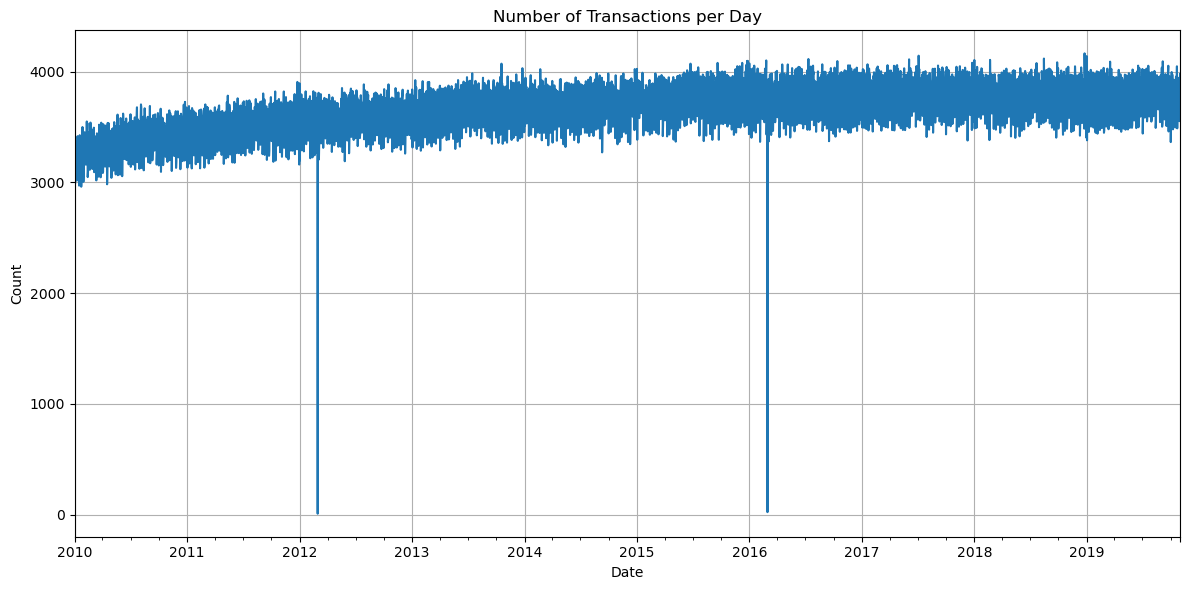

In [15]:
transactions_df.resample('D').size().plot(figsize=(12, 6))
plt.title('Number of Transactions per Day')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Importe total transaccionado a lo largo del tiempo

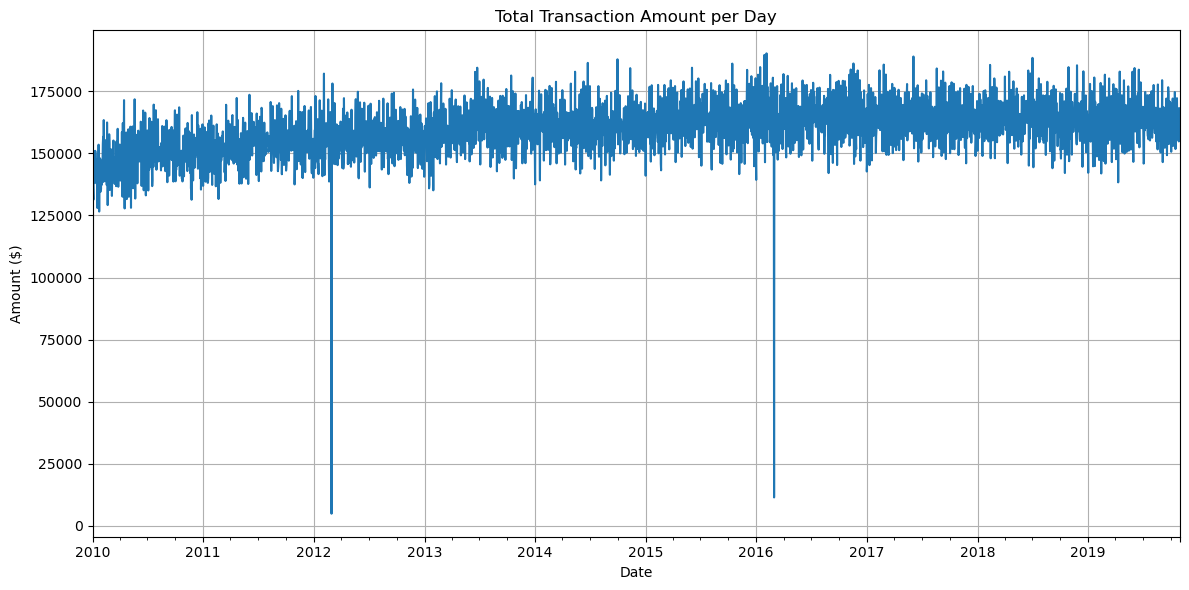

In [16]:
transactions_df.resample('D')['amount'].sum().plot(figsize=(12, 6))
plt.title('Total Transaction Amount per Day')
plt.xlabel('Date')
plt.ylabel('Amount ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Valores perdidos

In [17]:
transactions_df.isna().sum()

id                       0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
dtype: int64

In [23]:
top_client_id = transactions_df['client_id'].value_counts().idxmax()
top_client_df = transactions_df[transactions_df['client_id'] == top_client_id].copy()

print(f"Usuario con más transacciones: {top_client_id}")
print(f"Número de transacciones: {len(top_client_df)}")

Usuario con más transacciones: 1098
Número de transacciones: 48479


In [31]:
top_client_df.head()

,id,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
date,,,,,,,,,,,
2010-01-01 05:15:00,7475527,1098,4626,6.76,Swipe Transaction,50867,Hawarden,IA,51023.0,5541,NaN
2010-01-01 06:52:00,7475751,1098,4626,46.25,Swipe Transaction,40616,Battle Creek,IA,51006.0,7349,NaN
2010-01-01 08:08:00,7476070,1098,4626,-66.00,Swipe Transaction,50867,Hawarden,IA,51023.0,5541,NaN
2010-01-01 08:09:00,7476076,1098,4626,66.00,Swipe Transaction,50867,Hawarden,IA,51023.0,5541,NaN
2010-01-01 08:21:00,7476110,1098,4626,30.89,Swipe Transaction,50867,Hawarden,IA,51023.0,5541,NaN


### Partición del conjunto de datos

In [32]:
amount = top_client_df.loc[:,'amount']
amount.describe()

count    48479.000000
mean        30.119573
std         65.490261
min       -496.000000
25%          8.760000
50%         51.000000
75%         75.000000
max       2697.930000
Name: amount, dtype: float64

In [33]:
a_train, a_test = amount.iloc[:40000], amount.iloc[40000:]

a_train.shape, a_test.shape

((40000,), (8479,))

### Normalización

In [36]:
w = 10

sdscaler = MinMaxScaler()

a_train_s = sdscaler.fit_transform(a_train.to_numpy().reshape(-1, 1))
a_test_s = sdscaler.transform(a_test.to_numpy().reshape(-1, 1))

windows_train = sliding_window_view(a_train_s, w+1, axis=0).copy()
X_train_w, y_train_w = windows_train.squeeze()[:,:-1], windows_train.squeeze()[:,-1]

windows_test = sliding_window_view(a_test_s, w+1, axis=0).copy()
X_test_w, y_test_w = windows_test.squeeze()[:,:-1], windows_test.squeeze()[:,-1]

In [37]:
X_train_w.shape, X_test_w.shape, y_train_w.shape, y_test_w.shape

((39990, 10), (8469, 10), (39990,), (8469,))

## K nearest neighbours

In [39]:
pd.set_option('display.precision', 5)
knn =  KNeighborsRegressor()

In [47]:
niter = 15
cv = 5

param = {'n_neighbors':[1, 3, 5, 7, 11, 15, 20, 25],
         'weights':['distance', 'uniform'],
         'leaf_size':[1, 5, 10, 15, 20, 25, 30],
         'metric': ['l2', 'l1', 'cosine']}

knn_bs = BayesSearchCV(knn,param,n_iter=niter,
                        cv=TimeSeriesSplit(n_splits=cv, gap=w+1),
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs=-1,
                        refit=True, random_state=0)
knn_bs.fit(X_train_w, y_train_w);

In [49]:
show_html(pd.DataFrame(knn_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
13,"{'leaf_size': 10, 'metric': 'l1', 'n_neighbors': 25, 'weights': 'distance'}",-0.00218,1
7,"{'leaf_size': 15, 'metric': 'l1', 'n_neighbors': 15, 'weights': 'distance'}",-0.00222,2
1,"{'leaf_size': 5, 'metric': 'cosine', 'n_neighbors': 25, 'weights': 'uniform'}",-0.00224,3
8,"{'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 20, 'weights': 'uniform'}",-0.00225,4
4,"{'leaf_size': 5, 'metric': 'l2', 'n_neighbors': 15, 'weights': 'distance'}",-0.00225,5


In [50]:
mean_squared_error(y_test_w,knn_bs.predict(X_test_w)), mean_absolute_error(y_test_w,knn_bs.predict(X_test_w))

(0.0027556281290258876, 0.036304375173885337)

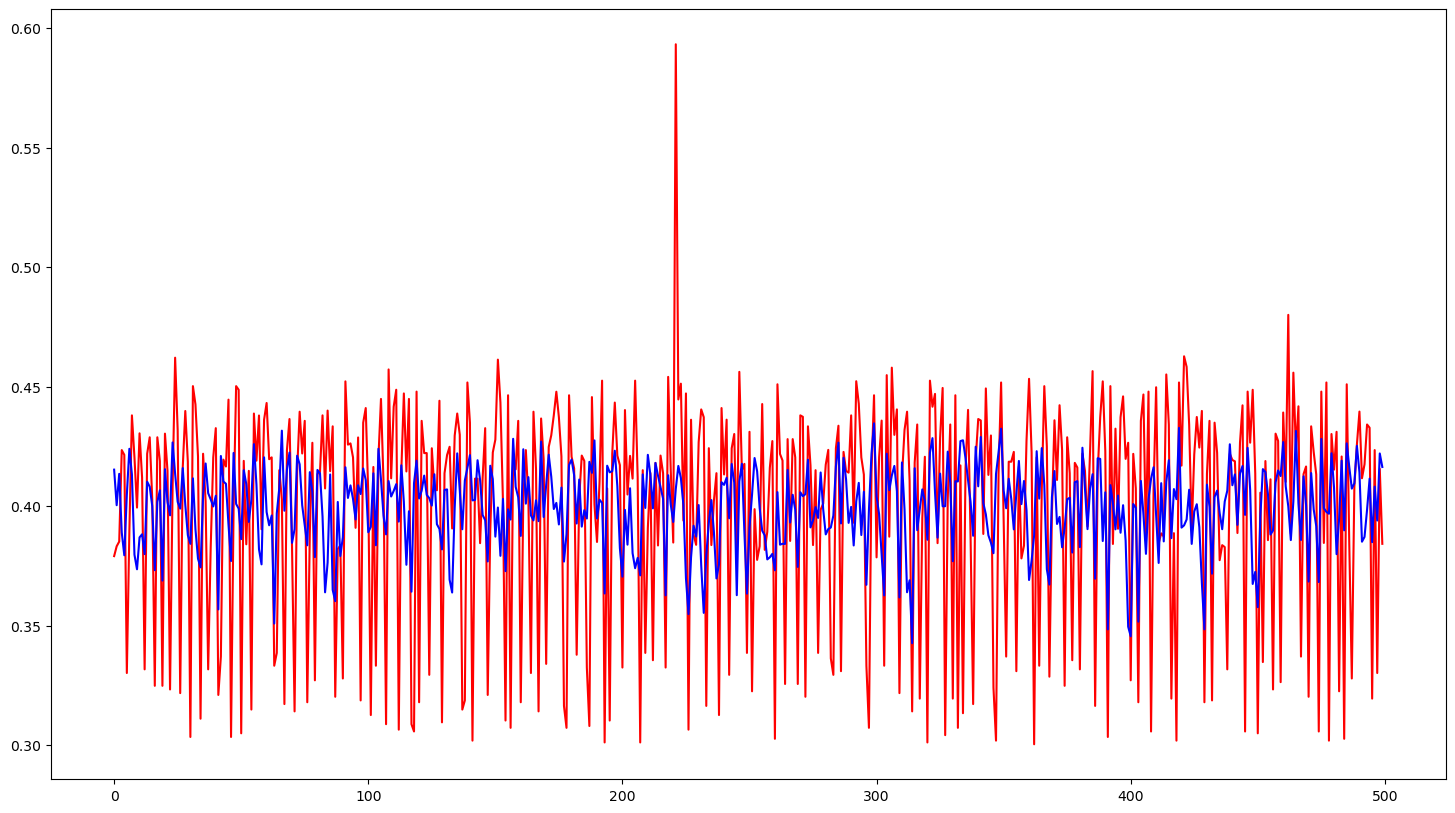

In [51]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:500],'r');
plt.plot(knn_bs.predict(X_test_w[:500,:]),'b');